GAN_Using_Pytorch
------

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML



In [2]:
# Set random seed for reproducibility
manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  6412


Hyperparameters
------

Let’s define some inputs for the run:

-  **data** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. 
-  **no_of_channels** - number of color channels in the input images. For color
   images this is 3
-  **latent** - length of latent vector
-  **gen_features** - relates to the depth of feature maps carried through the
   generator
-  **disc_features** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **no_of_gpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [3]:
data = "../data/dataset"
workers = 2
batch_size = 128
image_size = 64
no_of_channels = 3
latent = 100
gen_features  = 64
disc_features = 64
num_epochs = 250
lr = 0.0002
beta1 = 0.5
no_of_gpu = 1

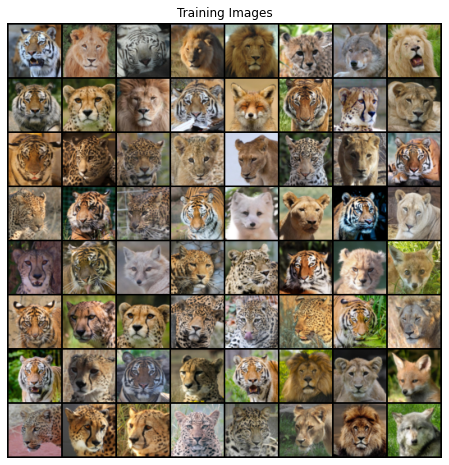

In [4]:
dataset = dset.ImageFolder(root=data,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and no_of_gpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Weight Initialization
------

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. 
The "weights_init" function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. 
This function is applied to the models immediately after initialization.




In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator
------

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, no_of_gpu):
        super(Generator, self).__init__()
        self.no_of_gpu = no_of_gpu
        self.generator = nn.Sequential(
            # layer_1 input is Z
            nn.ConvTranspose2d( latent, gen_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_features * 8),
            nn.ReLU(True),
           # layer_2 (64*8) x 4 x 4
            nn.ConvTranspose2d(gen_features * 8, gen_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features * 4),
            nn.ReLU(True),
            # layer_3  (64*4) x 8 x 8
            nn.ConvTranspose2d( gen_features * 4, gen_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features * 2),
            nn.ReLU(True),
            # layer_4  (64*2) x 16 x 16
            nn.ConvTranspose2d( gen_features * 2, gen_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features),
            nn.ReLU(True),
            # layer_5 (64) x 32 x 32
            nn.ConvTranspose2d( gen_features, no_of_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # output (3) x 64 x 64
            
        )

    def forward(self, input):
        return self.generator(input)

In [7]:
generatorNet = Generator(no_of_gpu).to(device)

if (device.type == 'cuda') and (no_of_gpu > 1):
    generatorNet = nn.DataParallel(generatorNet, list(range(no_of_gpu)))

generatorNet.apply(weights_init)

print(generatorNet)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

Discriminator
------

In [8]:
class Discriminator(nn.Module):
    def __init__(self, no_of_gpu):
        super(Discriminator, self).__init__()
        self.no_of_gpu = no_of_gpu
        self.disc = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(no_of_channels, disc_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # layer_2 (64) x 32 x 32
            nn.Conv2d(disc_features, disc_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # layer_3, (64*2) x 16 x 16
            nn.Conv2d(disc_features * 2, disc_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # layer_4,(64*4) x 8 x 8
            nn.Conv2d(disc_features * 4, disc_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # layer_5, (64*8) x 4 x 4
            nn.Conv2d(disc_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.disc(input)

In [9]:
discrimNet = Discriminator(no_of_gpu).to(device)

if (device.type == 'cuda') and (no_of_gpu > 1):
    discrimNet = nn.DataParallel(discrimNet, list(range(no_of_gpu)))
    
discrimNet.apply(weights_init)

print(discrimNet)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


loss and optimizer
------

In [10]:
loss = nn.BCELoss()

fixed_noise = torch.randn(64, latent, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(discrimNet.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generatorNet.parameters(), lr=lr, betas=(beta1, 0.999))

Training_Step
------

In [11]:
# Training Loop


img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # Training Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))

        ## Train with all-real batch
        
        discrimNet.zero_grad()
        real_data = data[0].to(device)
        #print("real_data", real_data)
        batch_size = real_data.size(0)
        #print("batch_size", batch_size)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        #print("label", label)
        # Forward pass real batch
        output = discrimNet(real_data).view(-1)
        # loss on all-real batch
        errorD_real = loss(output, label)
        # gradients 
        errorD_real.backward()
        D_x = output.mean().item()
        

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, latent, 1, 1, device=device)
        # Generate fake image batch with generator
        fake = generatorNet(noise)
        label.fill_(fake_label)
        
        output = discrimNet(fake.detach()).view(-1)
        
        errorD_fake = loss(output, label)
        
        errorD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errorD = errorD_real + errorD_fake
        # Update Discriminator
        optimizerD.step()

        # Training Generator network: maximize log(D(G(z)))
                
        generatorNet.zero_grad()
        label.fill_(real_label)  
        
        output = discrimNet(fake).view(-1)
        
        errorG = loss(output, label)
        
        errorG.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], \nLoss_D: {errorD.item():.4f}, Loss_G: {errorG.item():.4f}, D(x): {D_x:.4f}, D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')
            
        
        # Save Losses for plotting later
        G_losses.append(errorG.item())
        D_losses.append(errorD.item())
        
        # Check how the generator is doing by saving Generator's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generatorNet(fixed_noise).detach().cpu()
                #print("fake", fake)
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            #print(img_list)
            
        iters += 1


parameters = {
    "generatorNet_state": generatorNet.state_dict(),
    "discrimNet_state": discrimNet.state_dict(),
}

GAN = "GAN_Model.pth"
torch.save(parameters, GAN)

print(f'training complete. file saved to {GAN}')

Starting Training Loop...
Epoch [1/250], 
Loss_D: 1.4678, Loss_G: 6.9774, D(x): 0.6551, D(G(z)): 0.5540/0.0015
Epoch [2/250], 
Loss_D: 0.3377, Loss_G: 9.7932, D(x): 0.8101, D(G(z)): 0.0107/0.0001
Epoch [3/250], 
Loss_D: 3.8792, Loss_G: 19.2111, D(x): 0.9303, D(G(z)): 0.9600/0.0000
Epoch [4/250], 
Loss_D: 3.8889, Loss_G: 19.1912, D(x): 0.9315, D(G(z)): 0.9646/0.0000
Epoch [5/250], 
Loss_D: 0.6083, Loss_G: 25.6461, D(x): 0.7151, D(G(z)): 0.0000/0.0000
Epoch [6/250], 
Loss_D: 0.4000, Loss_G: 8.7236, D(x): 0.7938, D(G(z)): 0.0007/0.0018
Epoch [7/250], 
Loss_D: 0.7872, Loss_G: 14.2196, D(x): 0.6762, D(G(z)): 0.0005/0.0000
Epoch [8/250], 
Loss_D: 0.8483, Loss_G: 5.6968, D(x): 0.9046, D(G(z)): 0.4399/0.0065
Epoch [9/250], 
Loss_D: 0.5825, Loss_G: 5.0170, D(x): 0.8443, D(G(z)): 0.2797/0.0098
Epoch [10/250], 
Loss_D: 0.7779, Loss_G: 4.0648, D(x): 0.7059, D(G(z)): 0.2030/0.0246
Epoch [11/250], 
Loss_D: 0.9967, Loss_G: 3.6155, D(x): 0.5655, D(G(z)): 0.0259/0.0574
Epoch [12/250], 
Loss_D: 0.4222, 

Epoch [97/250], 
Loss_D: 0.3978, Loss_G: 5.0155, D(x): 0.7888, D(G(z)): 0.0968/0.0150
Epoch [98/250], 
Loss_D: 0.4779, Loss_G: 5.8006, D(x): 0.9158, D(G(z)): 0.2657/0.0097
Epoch [99/250], 
Loss_D: 0.7469, Loss_G: 8.0810, D(x): 0.9315, D(G(z)): 0.4120/0.0020
Epoch [100/250], 
Loss_D: 0.3512, Loss_G: 4.9890, D(x): 0.8898, D(G(z)): 0.1742/0.0182
Epoch [101/250], 
Loss_D: 0.4556, Loss_G: 5.7122, D(x): 0.8518, D(G(z)): 0.2074/0.0121
Epoch [102/250], 
Loss_D: 1.0436, Loss_G: 9.5996, D(x): 0.9413, D(G(z)): 0.5514/0.0013
Epoch [103/250], 
Loss_D: 0.4383, Loss_G: 6.8444, D(x): 0.9576, D(G(z)): 0.2811/0.0028
Epoch [104/250], 
Loss_D: 0.5126, Loss_G: 5.2539, D(x): 0.8051, D(G(z)): 0.1892/0.0176
Epoch [105/250], 
Loss_D: 0.4527, Loss_G: 5.9086, D(x): 0.9104, D(G(z)): 0.2651/0.0062
Epoch [106/250], 
Loss_D: 0.2892, Loss_G: 5.0707, D(x): 0.9145, D(G(z)): 0.1592/0.0116
Epoch [107/250], 
Loss_D: 0.6915, Loss_G: 4.1941, D(x): 0.5860, D(G(z)): 0.0129/0.0393
Epoch [108/250], 
Loss_D: 0.4632, Loss_G: 6.27

Epoch [192/250], 
Loss_D: 1.5271, Loss_G: 1.7594, D(x): 0.4037, D(G(z)): 0.0280/0.3658
Epoch [193/250], 
Loss_D: 0.2468, Loss_G: 5.6083, D(x): 0.8872, D(G(z)): 0.0870/0.0146
Epoch [194/250], 
Loss_D: 0.3532, Loss_G: 6.4961, D(x): 0.9312, D(G(z)): 0.2107/0.0036
Epoch [195/250], 
Loss_D: 0.2343, Loss_G: 4.3687, D(x): 0.8837, D(G(z)): 0.0874/0.0230
Epoch [196/250], 
Loss_D: 0.1743, Loss_G: 5.0023, D(x): 0.9601, D(G(z)): 0.1117/0.0139
Epoch [197/250], 
Loss_D: 0.1940, Loss_G: 4.9060, D(x): 0.9018, D(G(z)): 0.0744/0.0167
Epoch [198/250], 
Loss_D: 0.1821, Loss_G: 4.9804, D(x): 0.9493, D(G(z)): 0.1058/0.0148
Epoch [199/250], 
Loss_D: 0.1662, Loss_G: 4.6479, D(x): 0.9308, D(G(z)): 0.0802/0.0195
Epoch [200/250], 
Loss_D: 0.1289, Loss_G: 4.4888, D(x): 0.9462, D(G(z)): 0.0661/0.0193
Epoch [201/250], 
Loss_D: 0.1838, Loss_G: 4.8965, D(x): 0.9224, D(G(z)): 0.0896/0.0143
Epoch [202/250], 
Loss_D: 0.1426, Loss_G: 4.5247, D(x): 0.9472, D(G(z)): 0.0789/0.0181
Epoch [203/250], 
Loss_D: 0.1461, Loss_G: 4

Results
-------


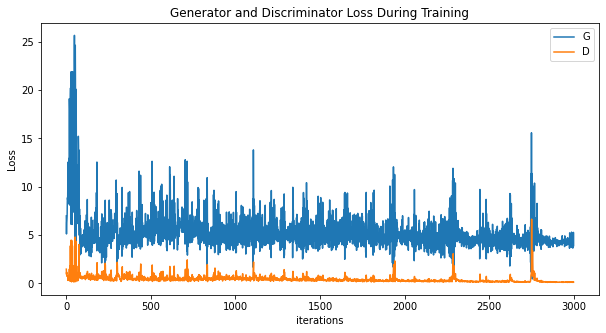

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Real Images vs. Fake Images**


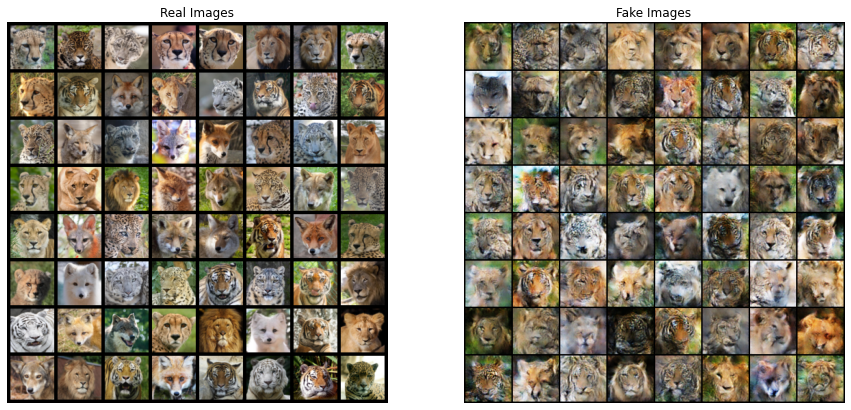

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()